In [3]:
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List,Tuple
%matplotlib inline

In [4]:
noisy_blob = make_moons(n_samples=1000,noise = 0.1)
noisy_moon = make_blobs(n_samples=300,centers=2,
                             cluster_std=[1, 0.8],
                             random_state=0)


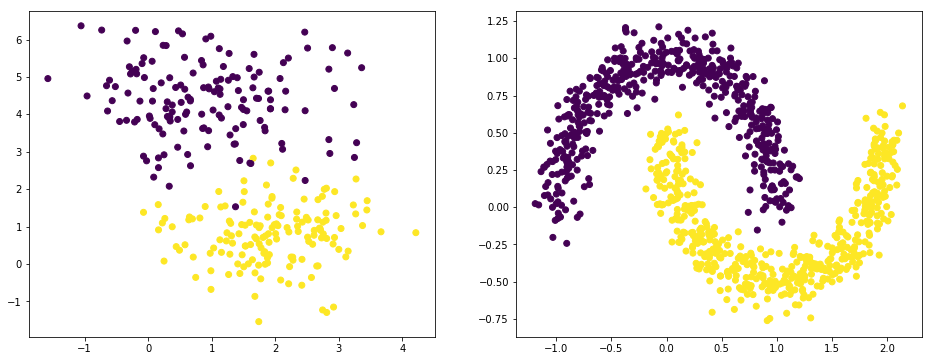

In [5]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(noisy_moon[0][:,0],noisy_moon[0][:,1],c=noisy_moon[1])
plt.subplot(122)
plt.scatter(noisy_blob[0][:,0],noisy_blob[0][:,1],c = noisy_blob[1])

In [6]:
class net(nn.Module):
    def __init__(self):
        super(net,self).__init__()
        self.fc1 = nn.Linear(2,20)
        self.fc2 = nn.Linear(20,10)
        self.fc3 = nn.Linear(10,2)
    def forward(self,input):
        out = self.fc1(input)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
def plot_regions(net,X,Y):
    device = net.parameters().__next__().device

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
    orignal_size = xx.shape
    X_ = torch.Tensor([xx.reshape(-1),yy.reshape(-1)]).transpose(0,1)
    X_= X_.to(device)
    
    net.eval()
    pred = F.softmax(net(X_),1)
    pred = pred[:,1].reshape(orignal_size)
    plt.contourf(xx,yy,pred.detach().cpu(),alpha=0.4)
    plt.scatter(X[:, 0][:20], X[:, 1][:20], c=Y[:20], edgecolor='k')
    plt.scatter(X[:, 0][20:], X[:, 1][20:], c=Y[20:],s=20, edgecolor='k',alpha=0.3)
    net.train()
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
#     perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
class VATGenerator(object):
    def __init__(self, net: nn.Module, xi=1e-2, eplision=1, ip=1, axises: List[int] = [1, 2, 3]) -> None:
        """VAT generator based on https://arxiv.org/abs/1704.03976
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps: hyperparameter of VAT (default: 1.0)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATGenerator, self).__init__()
        self.xi = xi
        self.eps = eplision
        self.ip = ip
        self.net = net
        self.axises = axises

    #         self.entropy = Entropy_2D()  # type: Tensor # shape:

    @staticmethod
    def _l2_normalize(d) -> Tensor:
        # d = d.cpu().numpy()
        # d /= (np.sqrt(np.sum(d ** 2, axis=(1, 2, 3))).reshape((-1, 1, 1, 1)) + 1e-16)
        # return torch.from_numpy(d)
        d_reshaped = d.view(d.shape[0], 2)
        d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-16
        # print('d_noise shape:', d.shape)

        #         print(d.view(d.shape[0], -1).norm(dim=1))
        #         assert torch.allclose(d.view(d.shape[0], -1).norm(dim=1), torch.ones(d.shape[0]).to(d.device))

        return d

    @staticmethod
    def kl_div_with_logit(q_logit, p_logit, axises):
        '''
        :param q_logit:it is like the y in the ce loss
        :param p_logit: it is the logit to be proched to q_logit
        :return:
        '''
        q = F.softmax(q_logit, dim=1)
        logq = F.log_softmax(q_logit, dim=1)
        logp = F.log_softmax(p_logit, dim=1)

        qlogq = (q * logq)[:, axises].sum(dim=1)
        qlogp = (q * logp)[:, axises].sum(dim=1)
        # assert (qlogq - qlogp<0).sum()==0

        return qlogq - qlogp

    @staticmethod
    def l2_loss2d(q_logit, p_logit, axises):
        q_prob = F.softmax(q_logit, 1)
        p_prob = F.softmax(p_logit, 1)
        loss = (q_prob - p_prob).pow(2)[:, axises].sum(dim=1)
        return loss

    @staticmethod
    def l1_loss2d(q_logit, p_logit, axises):
        q_prob = F.softmax(q_logit, 1)
        p_prob = F.softmax(p_logit, 1)
        loss = torch.abs((q_prob - p_prob))[:, axises].sum(dim=1)
        return loss

    def __call__(self, img: Tensor, loss_name='kl') -> Tuple[Tensor, Tensor]:
        tra_state = self.net.training
        self.net.eval()
        with torch.no_grad():
            pred = self.net(img)

        # prepare random unit tensor
        d = torch.Tensor(img.size()).normal_()  # 所有元素的std =1, average = 0
        d = self._l2_normalize(d).to(img.device)
        assert torch.allclose(d.view(d.shape[0], -1).norm(dim=1),
                              torch.ones(d.shape[0]).to(img.device)), 'The L2 normalization fails'
        self.net.zero_grad()
        for _ in range(self.ip):
            d = self.xi * self._l2_normalize(d).to(img.device)
            d.requires_grad = True
            y_hat = self.net(img + d)
            delta_kl: torch.Tensor
            # Here the pred is the reference as y in cross-entropy.

            if loss_name == 'kl':
                delta_kl = self.kl_div_with_logit(pred.detach(), y_hat, self.axises)  # B/H/W
            elif loss_name == 'l2':
                delta_kl = self.l2_loss2d(pred.detach(), y_hat, self.axises)  # B/H/W
            elif loss_name == 'l1':
                delta_kl = self.l1_loss2d(pred.detach(), y_hat, self.axises)  # B/H/W
            else:
                raise NotImplementedError

            # todo: the mask

            delta_kl.mean().backward()

            d = d.grad.data.clone().cpu()
            self.net.zero_grad()
        ##
        d = self._l2_normalize(d).to(img.device)
        r_adv = self.eps * d
        # compute lds
        img_adv = img + r_adv.detach()
        if tra_state:
            self.net.train()
        assert self.net.training == tra_state
        # img_adv = torch.clamp(img_adv, 0, 1)

        return img_adv.detach(), r_adv.detach()
    

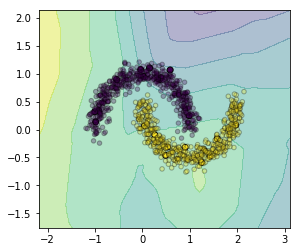

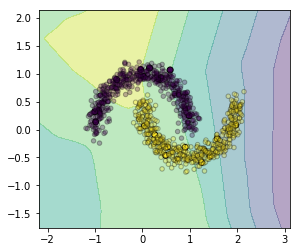

In [7]:
device = torch.device('cpu')
net1 = net()
net2= net()

optim1= torch.optim.Adam(net1.parameters())
optim2= torch.optim.Adam(net2.parameters())
net1.to(device)
net2.to(device)
plt.figure(figsize=(4.5,4))
plot_regions(net1,noisy_blob[0],noisy_blob[1])
plt.figure(figsize=(4.5,4))
plot_regions(net2,noisy_blob[0],noisy_blob[1])

In [29]:
criterion = nn.CrossEntropyLoss()


def suploss():
    id = np.random.choice(noisy_blob[0][:20].shape[0], 10)
    x = torch.from_numpy(noisy_blob[0][id]).float()
    y = torch.from_numpy(noisy_blob[1][id]).long()
    x, y = x.to(device), y.to(device)
    pred1 = net1(x)
    pred2 = net2(x)
    loss1 = criterion(pred1, y)
    loss2 = criterion(pred2, y)
    loss = loss1 + loss2
    optim1.zero_grad()
    optim2.zero_grad()
    loss.backward()
    optim1.step()
    optim2.step()
    return loss.item()


def jsdloss():
    id = np.random.choice(noisy_blob[0][:20].shape[0], 10)
    x = torch.from_numpy(noisy_blob[0][id]).float()
    y = torch.from_numpy(noisy_blob[1][id]).long()
    x, y = x.to(device), y.to(device)
    pred1 = net1(x)
    pred2 = net2(x)
    loss1 = criterion(pred1, y)
    loss2 = criterion(pred2, y)
    loss = loss1 + loss2
    optim1.zero_grad()
    optim2.zero_grad()
    loss.backward()
    optim1.step()
    optim2.step()
    return loss.item()


def advloss():
    id = np.random.choice(noisy_blob[0].shape[0], 20)
    x = torch.from_numpy(noisy_blob[0][id]).float()
    #     y = torch.from_numpy(noisy_blob[1][id]).long()
    x = x.to(device)
    x.requires_grad = True
    optim1.zero_grad()
    optim2.zero_grad()
    real_pred_1 = net1(x)
    real_pred_2 = net2(x)
    loss1 = criterion(net1(x), real_pred_1.max(1)[1])
    loss1.backward()

    adv_x_1 = fgsm_attack(x, 0.1, x.grad.clone()).detach()
    x.grad.zero_()
    loss2 = criterion(net2(x), real_pred_2.max(1)[1])
    loss2.backward()
    adv_x_2 = fgsm_attack(x, 0.1, x.grad.clone()).detach()
    real_pred_1 = net1(x)
    real_pred_2 = net2(x)

    adv_pred_1 = net1(adv_x_1)
    adv_pred_2 = net2(adv_x_2)
    optim1.zero_grad()
    optim2.zero_grad()

    loss = F.kl_div(F.log_softmax(adv_pred_1, 1), F.softmax(real_pred_2, 1).detach()) + \
           F.kl_div(F.log_softmax(adv_pred_2, 1), F.softmax(real_pred_1, 1).detach())
    (loss).backward()

    optim2.step()
    optim1.step()
    return loss.item()


def advvatloss():
    id = np.random.choice(noisy_blob[0].shape[0], 20)
    x = torch.from_numpy(noisy_blob[0][id]).float()
    x = x.to(device)
    x.requires_grad = True
    optim1.zero_grad()
    optim2.zero_grad()
    real_pred_1 = net1(x)
    real_pred_2 = net2(x)
    #     print(x.shape)
    try:
        x.grad.zeros()
    except:
        pass
    adv_x_1, noise1 = VATGenerator(net1, eplision=0.1, axises=[0, 1])(x, loss_name='kl')
    try:
        x.grad.zeros()
    except:
        pass
    adv_x_2, _ = VATGenerator(net2, eplision=0.1, axises=[0, 1])(x, loss_name='kl')

    adv_pred_1 = net1(adv_x_1)
    adv_pred_2 = net2(adv_x_2)
    optim1.zero_grad()
    optim2.zero_grad()

    loss = \
        F.kl_div(F.log_softmax(adv_pred_1, 1), F.softmax(real_pred_1, 1).detach()) + \
        F.kl_div(F.log_softmax(adv_pred_2, 1), F.softmax(real_pred_2, 1).detach())
    (loss*0.01).backward()

    optim2.step()
    optim1.step()
    return loss.item()

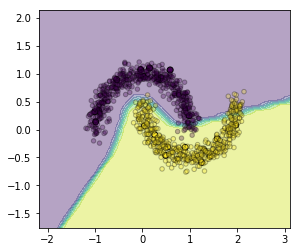

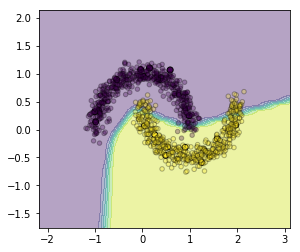

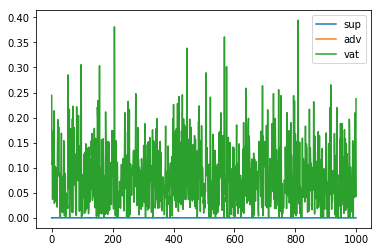

In [32]:
adv_loss = []
sup_loss = []
vat_loss =[]
for i in range(1000):
    sup_loss.append(suploss())
#     adv_loss.append(advloss())
    vat_loss.append(advvatloss())

plt.figure(1, figsize=(4.5, 4))
plt.clf()
plot_regions(net1, noisy_blob[0], noisy_blob[1])
plt.figure(2, figsize=(4.5, 4))
plt.clf()
plot_regions(net2, noisy_blob[0], noisy_blob[1])
plt.figure(3)
plt.clf()
plt.plot(sup_loss, label='sup')
plt.plot(adv_loss, label='adv')

plt.plot(vat_loss, label='vat')
plt.legend()
plt.pause(0.000001)